## Neural Networks

In this example we train a neural network from scratch to detect handwritten digits. We use [PyTorch](https://pytorch.org/) (a common deep learning library) to define our network: it allows us to make very explicit the structure of the network and the training loop. Note that neural networks are really useful in *both* supervised and unsuperised machine learning regimes. In this example we use a neural network to address a supervised learning problem.

Before looking at this notebook, have a play with [A Neural Network Playground](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.81156&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false) which allows you to interactively modify with neural network hyperparameters (e.g. learning rate, network architecture, activation function) and see how changing these parameters affects the outcome. For example:
- Note that if you choose your activation function to be 'linear', you can change the other parameters as much as you want, but you'll never be able to learn the first domain (where the inside of the circle is orange and the outside is blue): this is because a circle is non-linear, so it cannot be learned by compositions of linear maps! You need your activation function to add some non-linearity to it. For example if we choose ReLU and keep our learning rate 0.03 then we should be able to learn such a domain.
- But we can learn the third domain (the one where orange and blue can be divided by a diagonal line) using a 'linear' activation function: this is because the two domain are linearly separable, so this can be learned by just a composition of linear functions.
- Play around with the learning rate: note that if the learning rate is too high the network does not converge, and if it is too low it converges too slowly.

In [1]:
# Import some libraries
import torch
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

We download the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset of handwritten digits.

In [2]:
# Download the train-test split of the data
train = datasets.MNIST('', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST('', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

What does the data look like? Each datapoint is a 28x28 pixels black and white image of a digit between 0 and 9.

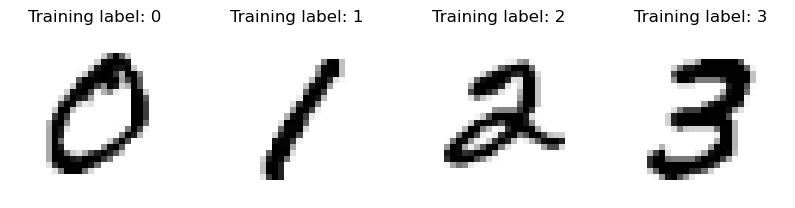

In [4]:
# Get out some examples and their labels
examples = [train.data[1], train.data[3], train.data[5], train.data[7]]
labels = [train.targets[1], train.targets[3], train.targets[5], train.targets[7]]

# Some boring plotting code
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, examples, labels):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r)
    ax.set_title("Training label: %i" % label)

Batch both the training and the testing data, for a given batch size.

In [ ]:
# The batch size is an example of an hyperparameter (the dimension of the batch size affects the learning): this is a hyperparameter you can change.
batch_size = 500

# Batch the training and testing data
trainset = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

Now that our data is ready, we need to define a network. We define a network with two hidden layers of 16 neurons each.

In [ ]:
# This class defines the neural network architecture
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Input Layer (we have 28x28 pixels, so the input layer must be of size 28*28, while the next layer is 16 neurons big)
        self.input = nn.Linear(28*28, 16)

        # Hidden layers (each of them have 16 layers)
        self.hidden1 = nn.Linear(16, 16)
        self.hidden2 = nn.Linear(16, 16)

        # Output layer (we are classifying digits between 0 and 9, so we have 10 classes, hence the output layer must have 10 neurons)
        self.output = nn.Linear(16, 10)

    def forward(self, x):
        # We use ReLu activation function on all layers (for other activation functions see https://machinelearningmastery.com/activation-functions-in-pytorch/)
        x = F.relu(self.input(x))
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))

        # We do not use the ReLU activation function on the output
        x = self.output(x)

        # We apply log softmax to the output
        return F.log_softmax(x, dim=1)

# Define the network
net = Net()

# Print the network we have just defined (note that this network has all the weights and biases randomly initialised)
print(net)

Now that we have both the data and the network we want to train it. We use the [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) (which is the usual loss function for multi-classification problems) and the Adam optimizer with learning rate `0.001`.

In [ ]:
# Define the loss function (this is the quantity we want to minimise during training)
loss_function = nn.CrossEntropyLoss()

# Define the optimizer algorithm
optimizer = optim.Adam(net.parameters(), lr=0.001)

Then, we go through the running loop, passing through the whole training set multiple times (for the specified number of epochs). Every 100 steps we evaluate on testing to see whether we are overfitting (by printing both the loss on training and testing).

In [ ]:
# Set the number of epochs (i.e. how many times we are saying the whole of the training data)
n_epochs = 10

# To record the loss every once in a while
losses = []

i = 0
# Loops over the number of epochs
for epoch in range(n_epochs):
    # Loop over the data in batches
    for data in trainset:
        # Upacks features and labels of the data
        X, y = data

        # Set gradients to zero
        net.zero_grad()

        # Passes the data through the network
        output = net(X.view(-1,28*28))

        # Loss calculation
        loss = loss_function(output, y)

        # Backpropagation and optimizer step
        loss.backward()
        optimizer.step()
        i+=1

        # Every 100 steps print the loss for each batch: it should go down if it is learning (and record it for plotting)
        if i%100==0:
            print(f'Loss at epoch {epoch} and step {i}: ', loss.item())
            losses.append(loss.item())


We can visualise the change in the loss through training by plotting them (this is called learning curve).

In [ ]:
# Plot the learning curve (training steps against loss)
plt.plot(range(len(losses)), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')

After training the model, we can compute the accuracy on unseen data (the testing data).

In [ ]:
# Count how many are correctly labelled and how many there are in total
correct = 0
total = 0

# Store the true and the correct labels
y_true = []
y_pred = []

# Store misclassified images
misclassified = []

with torch.no_grad():
    for data in testset:
        X, y = data
        # Get the network output
        output = net(X.view(-1,784))
        for idx, i, image in zip(range(len(output)), output, X):
            # Store true and predicted
            y_true.append(int(y[idx]))
            y_pred.append(int(torch.argmax(i)))

            # Was it labelled correctly?
            if torch.argmax(i) == y[idx]:
                correct += 1
            else:
                misclassified.append({'image': image, 
                                      'true_label': int(y[idx]), 
                                      'predicted_label': int(torch.argmax(i))})
        
            total += 1

print("Accuracy: ", round(correct/total, 3))

That is a nice accuracy, but wait! We know from Dr Will Pearse's talk that accuracy is not the best metric to measure how well our model is doing. Let build a confusion matrix instead, which compares how many samples are correctly classified for each class. 

In [ ]:
# Define the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = list(range(10)))
cm_display.plot()
plt.show()

The confusion matrix shows that we are performing well across all classes with slight variations. Let us look at some examples of misclassified examples.

In [ ]:
# Change this number to look at different examples
ex_number = 5

# Some boring plotting code
_, ax = plt.subplots()
ax.imshow(misclassified[ex_number]['image'].reshape(28,28), cmap=plt.cm.gray_r)
ax.set_axis_off()
print('True label:', misclassified[ex_number]['true_label'])
print('Predicted label:', misclassified[ex_number]['predicted_label'])


### Things to try
- As we did in the Neural Network Playground, play around with hyperparameters (network architectures, learning rate, batch size, activation function) and see how this changes the training and the learning curve.